In [2]:
!pip install unidecode

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 17.0 MB/s eta 0:00:00


In [32]:
import torch
import torch.nn as nn

seed = 1
torch.manual_seed(seed)

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import nltk
import unidecode

nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [33]:
dataset_path = '/content/all-data.csv'
headers = ['sentiment', 'content']
df = pd.read_csv(dataset_path, names=headers, encoding = 'ISO-8859-1')
df.head()

,sentiment,content
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...


In [34]:
classes = {
    class_name: idx for idx, class_name in enumerate(df.sentiment.unique()
    .tolist())
}
df['sentiment'] = df['sentiment'].apply(lambda x: classes[x])

In [35]:
df.head()

,sentiment,content
0,0,"According to Gran , the company has no plans t..."
1,0,Technopolis plans to develop in stages an area...
2,1,The international electronic industry company ...
3,2,With the new production plant the company woul...
4,2,According to the company 's updated strategy f...


In [36]:
english_stop_words = stopwords.words('english')
stemmer = PorterStemmer()

def text_normalize(text):
  text = text.lower()
  text = unidecode.unidecode(text)
  text = text.strip()
  text = re.sub(r'[^\w\s]','',text)
  text = ' '.join([word for word in text.split(' ') if word not in english_stop_words])
  text = ' '.join([stemmer.stem(word) for word in text.split(' ')])
  return text

In [37]:
df['content'] = df['content'].apply(lambda p: text_normalize(p))

In [39]:
df['content'].head()

,content
0,accord gran compani plan move product russia ...
1,technopoli plan develop stage area less 100000...
2,intern electron industri compani elcoteq laid ...
3,new product plant compani would increas capac ...
4,accord compani updat strategi year 20092012 b...


In [41]:
vocab = []
for sentence in df['content'].tolist():
  tokens = sentence.split()
  for token in tokens:
    if token not in vocab:
      vocab.append(token)

vocab.append('UNK')
vocab.append('PAD')
word_to_idx = {word: idx for idx, word in enumerate(vocab)}
vocab_size = len(vocab)



In [43]:
vocab[:10]

['accord',
 'gran',
 'compani',
 'plan',
 'move',
 'product',
 'russia',
 'although',
 'grow',
 'technopoli']

In [46]:
list(word_to_idx.items())[:10]

[('accord', 0),
 ('gran', 1),
 ('compani', 2),
 ('plan', 3),
 ('move', 4),
 ('product', 5),
 ('russia', 6),
 ('although', 7),
 ('grow', 8),
 ('technopoli', 9)]

In [49]:
def transform(text, word_to_idx, max_seq_len):
  tokens = []
  for w in text.split():
    try:
      w_ids = word_to_idx[w]
    except:
      w_ids = word_to_idx['UNK']
    tokens.append(w_ids)
  if len(tokens) < max_seq_len:
    tokens = tokens + [word_to_idx['PAD']] * (max_seq_len - len(tokens))
  elif len(tokens) > max_seq_len:
    tokens = tokens[:max_seq_len]

  return tokens

In [50]:
val_size = 0.2
test_size = 0.125
is_shuffle = True
texts = df['content'].tolist()
labels = df['sentiment'].tolist()

X_train, X_val, y_train, y_val = train_test_split(texts, labels, test_size=val_size, random_state=seed, shuffle=is_shuffle)

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=test_size, random_state=seed, shuffle=is_shuffle)

In [51]:
class FinancialNews(Dataset):
  def __init__(
      self,
      X, y,
      word_to_idx,
      max_seq_len,
      transform=None
  ):
    self.texts = X
    self.labels = y
    self.word_to_idx = word_to_idx
    self.max_seq_len = max_seq_len
    self.transform = transform

  def __len__(self):
    return len(self.texts)
  def __getitem__(self, idx):
    text = self.texts[idx]
    label = self.labels[idx]
    if self.transform:
      text = self.transform(text, self.word_to_idx, self.max_seq_len)
    text = torch.tensor(text)
    return text, label


In [52]:
max_seq_len = 32

train_dataset = FinancialNews(X_train, y_train, word_to_idx, max_seq_len, transform=transform)

val_dataset = FinancialNews(X_val, y_val, word_to_idx, max_seq_len, transform=transform)

test_dataset = FinancialNews(X_test, y_test, word_to_idx, max_seq_len, transform=transform)

train_batch_size = 128
test_batch_size = 8

train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=test_batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False)

In [53]:
class SentimentClassifier(nn.Module):
  def __init__(self, vocab_size, embedding_dim, hidden_size, n_layers, n_classes, dropout_prob):
    super(SentimentClassifier, self).__init__()
    self.embedding = nn.Embedding(vocab_size, embedding_dim)
    self.rnn = nn.RNN(embedding_dim, hidden_size, n_layers, batch_first=True)
    self.norm = nn.LayerNorm(hidden_size)
    self.dropout = nn.Dropout(dropout_prob)
    self.fc1 = nn.Linear(hidden_size, 16)
    self.relu = nn.ReLU()
    self.fc2 = nn.Linear(16, n_classes)

  def forward(self, x):
    x = self.embedding(x)
    x, hn = self.rnn(x)
    x = x[:, -1, :]
    x = self.norm(x)
    x = self.dropout(x)
    x = self.fc1(x)
    x = self.relu(x)
    x = self.fc2(x)
    return x


In [54]:
n_classes = len(list(classes.keys()))
embedding_dim = 64
hidden_size = 64
n_layers = 2
dropout_prob = 0.2
device = 'cude' if torch.cuda.is_available() else 'cpu'

model = SentimentClassifier(vocab_size, embedding_dim, hidden_size, n_layers, n_classes, dropout_prob).to(device)

In [55]:
lr = 1e-4
epochs = 50

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [57]:
def fit(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    device,
    epochs
):
  train_losses = []
  val_losses = []

  for epoch in range(epochs):
    batch_train_losses = []
    model.train()
    for idx, (inputs, labels) in enumerate(train_loader):
      inputs = inputs.to(device)
      labels = labels.to(device)

      optimizer.zero_grad()
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

      batch_train_losses.append(loss.item())
    train_loss = sum(batch_train_losses) / len(batch_train_losses)
    train_losses.append(train_loss)

    val_loss, val_acc = evaluate(model, val_loader, criterion, device)
    val_losses.append(val_loss)

    print(f"EPOCH {epoch+1}/{epochs}, Train_Loss: {train_loss:.4f}\tValidation Loss: {val_loss:.4f}")

  return train_losses, val_losses

In [56]:
def evaluate(model, dataloader, criterion, device):
  model.eval()
  correct = 0
  total = 0
  losses = []
  with torch.no_grad():
    for inputs, labels in dataloader:
      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      losses.append(loss.item())

      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
  loss = sum(losses) / len(losses)
  acc = correct / total

  return loss, acc


In [58]:
train_losses, val_losses = fit(model, train_loader, val_loader, criterion, optimizer, device, epochs)

EPOCH 1/50, Train_Loss: 1.0102	Validation Loss: 0.9541
EPOCH 2/50, Train_Loss: 0.9439	Validation Loss: 0.9338
EPOCH 3/50, Train_Loss: 0.9337	Validation Loss: 0.9294
EPOCH 4/50, Train_Loss: 0.9317	Validation Loss: 0.9286
EPOCH 5/50, Train_Loss: 0.9311	Validation Loss: 0.9283
EPOCH 6/50, Train_Loss: 0.9286	Validation Loss: 0.9283
EPOCH 7/50, Train_Loss: 0.9287	Validation Loss: 0.9283
EPOCH 8/50, Train_Loss: 0.9302	Validation Loss: 0.9284
EPOCH 9/50, Train_Loss: 0.9311	Validation Loss: 0.9282
EPOCH 10/50, Train_Loss: 0.9294	Validation Loss: 0.9282
EPOCH 11/50, Train_Loss: 0.9300	Validation Loss: 0.9281
EPOCH 12/50, Train_Loss: 0.9295	Validation Loss: 0.9283
EPOCH 13/50, Train_Loss: 0.9283	Validation Loss: 0.9282
EPOCH 14/50, Train_Loss: 0.9282	Validation Loss: 0.9281
EPOCH 15/50, Train_Loss: 0.9256	Validation Loss: 0.9280
EPOCH 16/50, Train_Loss: 0.9286	Validation Loss: 0.9279
EPOCH 17/50, Train_Loss: 0.9276	Validation Loss: 0.9279
EPOCH 18/50, Train_Loss: 0.9320	Validation Loss: 0.9279
E

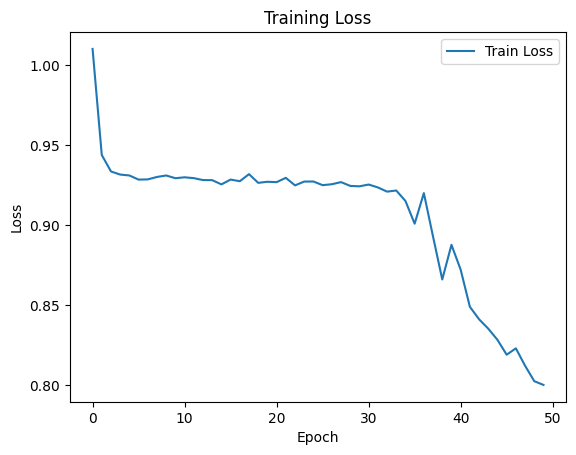

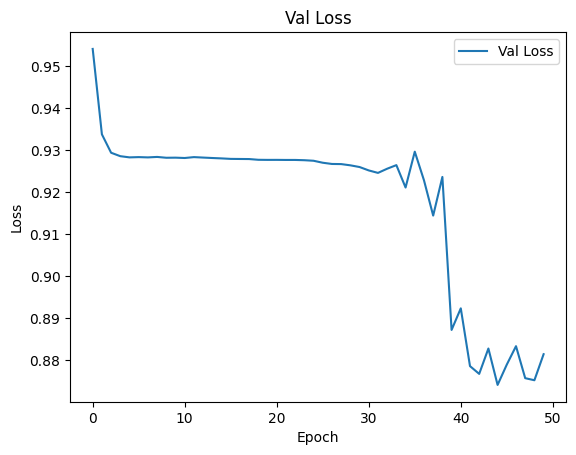

In [62]:


import matplotlib.pyplot as plt

plt.plot(train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()


plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Val Loss')
plt.legend()
plt.show()

In [63]:
val_loss, val_acc = evaluate(
    model,
    val_loader,
    criterion,
    device
)

test_loss, test_acc = evaluate(
    model,
    test_loader,
    criterion,
    device
)

print('Evaluation on val/test dataset')
print('Val accuracy: ', val_acc)
print('Test accuracy: ', test_acc)

Evaluation on val/test dataset
Val accuracy:  0.6257731958762887
Test accuracy:  0.6329896907216495


In [67]:
def inference(text, model, word_to_idx, max_seq_len, device):
    model.eval()
    text = text_normalize(text)
    text = transform(text, word_to_idx, max_seq_len)
    text = torch.tensor(text).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(text)
        _, predicted = torch.max(output, 1)
    return predicted.item()

# Example usage:
new_text = "This year's conference was a powerful bootcamp-style masterclass designed to unlock the future of business and cultivate a thriving network of successful entrepreneurs. Attendees gained invaluable leadership insights, mastered specialized CE-accredited training, and participated in dynamic, hands-on workshops aimed at supercharging their careers and business success."
predicted_class = inference(new_text, model, word_to_idx, max_seq_len, device)
print(f"Predicted class: {predicted_class}")

# Get the class name from the classes dictionary
predicted_class_name = [k for k, v in classes.items() if v == predicted_class][0]
print(f"Predicted class name: {predicted_class_name}")

Predicted class: 2
Predicted class name: positive
